# Week 7 Data acqusition from OpenBCI

In [28]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
import seaborn as sns
from scipy.signal import filtfilt
import pyxdf

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library

from sklearn.metrics import classification_report,confusion_matrix # Result representation

# OPENBCI

## 1 Read recorded data from OpenBCI (xdf file)

In [29]:
import pyxdf
import mne
import numpy as np
streams, header = pyxdf.load_xdf("data/sub-P001_ses-S001_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder

if streams[0]['info']['type'][0] == 'Markers': #Check
    raw_stream = streams[1]
    event_data = streams[0]
else:
    raw_stream = streams[0]
    event_data = streams[1]

raw_data = raw_stream["time_series"].T #From Steam variable this query is EEG data
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
raw_OpenBCI = mne.io.RawArray(raw_data, info, verbose=False)    


In [30]:
raw_OpenBCI

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [31]:
raw_OpenBCI.ch_names

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']

## 2. Filter

Effective window size : 8.192 (s)


C:\Users\pipo_\AppData\Local\Temp\ipykernel_8968\4197467807.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
c:\git\BCI-Class-Material\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


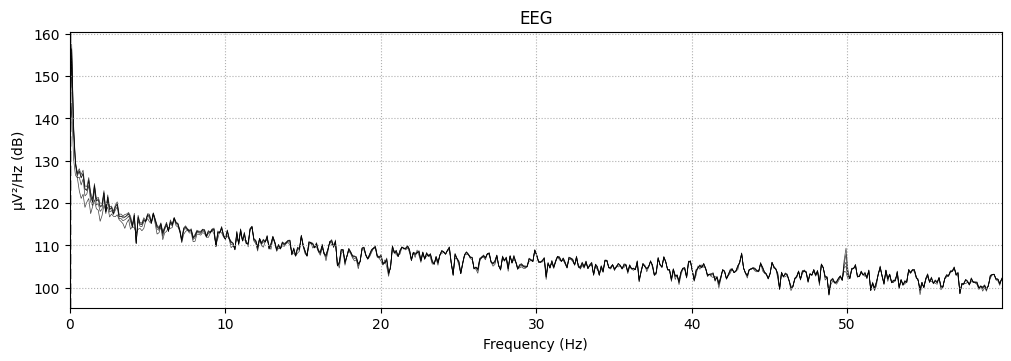

In [32]:
raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge

C:\Users\pipo_\AppData\Local\Temp\ipykernel_8968\2478548851.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  OpenBCI_filter.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
c:\git\BCI-Class-Material\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


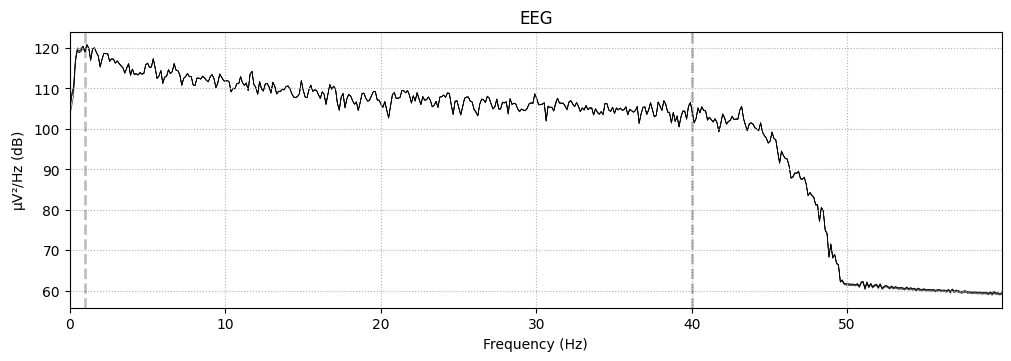

In [33]:
OpenBCI_filter = raw_OpenBCI.copy().filter(l_freq=1, h_freq=40) #band-pass function
OpenBCI_filter = OpenBCI_filter.copy().notch_filter(freqs=50) #notch filter function
OpenBCI_filter.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
plt.show()

## 3.Epoching

In [34]:
sfreq= 250
event_index = np.array(event_data["time_series"]).T[0] #Get all event marker of experiment 
event_timestamp = (np.array(event_data["time_stamps"]).T * sfreq) - (raw_stream['time_stamps'][0] * sfreq) #Timestamp when event marked

In [35]:
events_id2 = {'U': 1, 'R': 2, 'L': 3, 'D': 4, '': 5}

# Use vectorized mapping with np.vectorize
event_index = np.vectorize(events_id2.get)(event_index)

In [36]:
events2 = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

In [37]:
events2

array([[ 5286,     0,     1],
       [ 7536,     0,     2],
       [ 9783,     0,     4],
       [12035,     0,     3],
       [14289,     0,     3],
       [16534,     0,     4],
       [18784,     0,     2],
       [19545,     0,     5]])

In [38]:
OpenBCI_epochs = mne.Epochs(OpenBCI_filter, events2, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 1.5,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id2,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )

Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 8 events and 501 original time points ...
0 bad epochs dropped


In [39]:
OpenBCI_epochs

Number of events,8
Events,: 1D: 2L: 2R: 2U: 1
Time range,-0.500 – 1.500 s
Baseline,-0.500 – 0.000 s


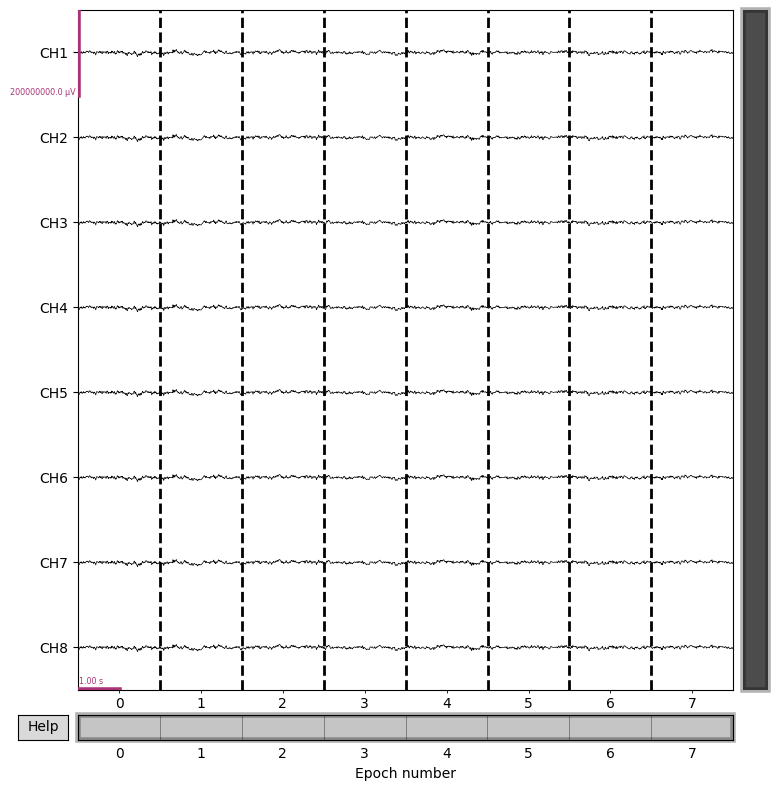

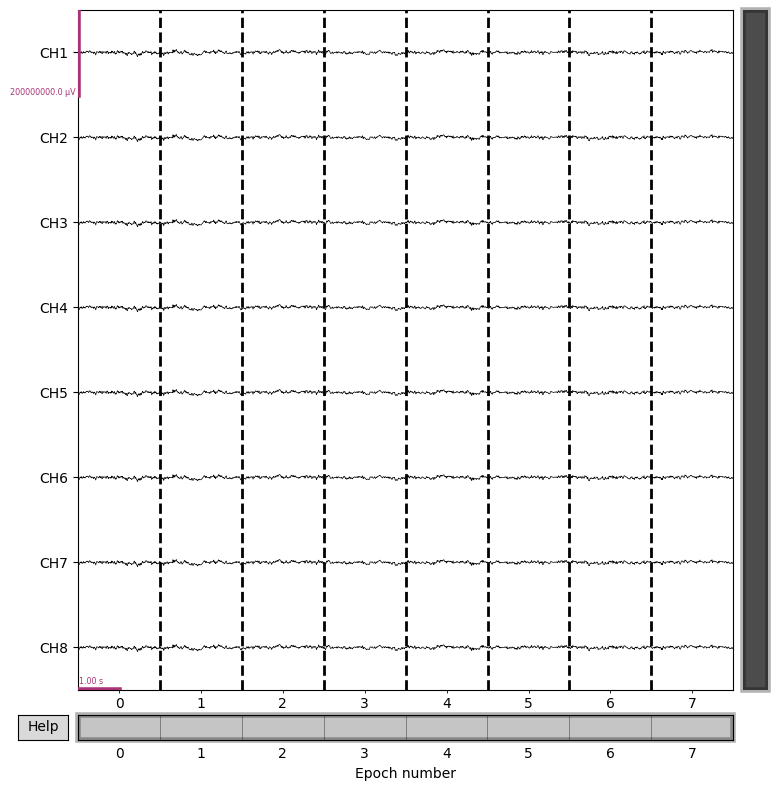

In [40]:
OpenBCI_epochs.plot(scalings = 100)